# X-Ray Classification Machine Learning Final Project
- Jack Wagner, Zach Bingaman



# Big Picture
- Our "Client" is a health center that is trying to automate the process of scanning through Xray images and having immediate results when an Xray is processed so the health center knows the body part the xray is representing and can use that information to further diagnose any possible problems with patients bones/body parts
- Our project seeks to classify Xray DICOM images of x-ray scanned body parts, which can be used in various health settings, and having this process automated can be very helpful for medical imaging. 
- Our solution would be used in health settings, and will be especially useful when classifying diseases determined by certain body parts
- The current solution uses trained professionals, usually doctors or physicians assistants, who can classify xray images based on experience and training. Many other people may not know the correct terminology or what to look for when classifying specific x-ray images. 
- This problem will be a supervised multi-label, multi-class classification problem using offline batch learning
- This is a computer vision problem
- Performance should be measured with accuracy since we are trying to identify body parts we can make sure to at least get a good idea of what body part the xray represents. Having inacurate labels would be of no use to the client, so the more accurate the algorithm can be, the better.
- The business metric is f1_score since the competition we joined on kaggle has f1_score as the metric
- The minimum performance we would need to reach the objective is to have over 75% accuracy with classifying the images, and to at least be predicting the correct areas of the body. There are some labels that tend to be paired, so there may be some overlap here.
- One of the comparable problems could be the MNIST fashion dataset. We will likely need to investigate the computer vision chapter in the book to better understand how to isolate image features to get better results with our model.
- Human expertise could be useful from medical professionals, anatomy majors, xray specialists
- Computer Vision and this problem can't really be done without Machine Learning or Neural Networks, so solving manually would literally be done by a human looking at the Xray images and classifying them by hand.
- We are assuming that the DICOM images are files and we are assuming each of them are the same size of 258 x 258
    - We will be using pydicom to parse the xray images given by kaggle
    - assuming that the labels are accurate for the images
    - assuming that the shape of the data is 258x258 features all pixel data
	- assuming that there is enough data to provide sufficient results
	- assuming that x-ray image classification is similar to other computer vision problems

# Important Note:
- This project is actually part of a kaggle competition so we will need to get our test results from submitting to the competition
- Here is the link to the competition [Competition Link](https://www.kaggle.com/competitions/unifesp-x-ray-body-part-classifier/overview)

In [2]:
!pip3 install pydicom
!pip3 install mlcm

In [12]:
# Imports cell
import sklearn
import pydicom
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
from tensorflow import keras
import seaborn as sns

import skimage
import skimage.exposure as exp
import skimage.filters as filters
from skimage.feature import SIFT

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  StandardScaler, MultiLabelBinarizer, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier StackingClassifier


from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score






# Get The Data

All of our Data is from Kaggle's *The UNIFESP X-Ray Body Part Classification Dataset*

Please visit this link to download the dataset we used for this project

[Data Download](https://www.kaggle.com/datasets/felipekitamura/unifesp-xray-bodypart-classification/download)

In [4]:
# Functions used throughout project
def get_label_dict(filename):
     df = pd.read_csv(filename,index_col='SOPInstanceUID')
     df = df['Target'].str.split().apply(lambda x: [int(i) for i in x])
     # print(label_list)
     return df.to_dict()
     
def get_files():
     return glob('train/train/train/*/*/*/*'), glob('test/test/test/*/*/*/*') 

classes_to_body_parts = {
    0: 'Abdomen',
    1:'Ankle',
    2: 'Cervical Spine',
    3: 'Chest',
    4: 'Clavicles',
    5: 'Elbow',
    6: 'Feet',
    7: 'Finger',
    8: 'Forearm',
    9: 'Hand',
    10: 'Hip',
    11: 'Knee',
    12: 'Lower Leg',
    13: 'Lumbar Spine',
    14: 'Others',
    15: 'Pelvis',
    16: 'Shoulder',
    17: 'Sinus',
    18: 'Skull',
    19: 'Thigh',
    20: 'Thoracic Spine',
    21: 'Wrist'
}

def get_label_from_SOPID(index):
    return train_label_dict[index]

def load_train_data(files):
     lst = [pydicom.dcmread(file).SOPInstanceUID for file in files]
     img_pixels = np.array([pydicom.dcmread(file).pixel_array.flatten() for file in files])

     
     data = pd.DataFrame(index=lst, data=img_pixels)
     data.reset_index(inplace=True)
     data['Label'] = data['index'].apply(get_label_from_SOPID)
     return data

def equalize_hist_data(files):
     lst = [pydicom.dcmread(file).SOPInstanceUID for file in files]
     img_pixels = np.array([exp.equalize_hist(pydicom.dcmread(file).pixel_array).flatten() for file in files])
     data = pd.DataFrame(index=lst, data=img_pixels)
     data.reset_index(inplace=True)
     data = data.drop(columns=['index'])
     return data

def load_test_data(files):
     lst = [pydicom.dcmread(file).SOPInstanceUID for file in files]
     img_pixels = np.array([pydicom.dcmread(file).pixel_array.flatten() for file in files])
     data = pd.DataFrame(index=lst, data=img_pixels)
     data.reset_index(inplace=True)
     return data

def show_images(image_files, num_images = 20, class_names = None, exp_equal = False, others = False):
     body_labels = [classes_to_body_parts[_class[0]] for _class in class_names[:num_images]]
     for i, (im,lbl) in enumerate(zip(image_files[:num_images], body_labels)):
        plt.subplot(7, 10, i+1)
        if lbl is not None:
                plt.title(lbl if class_names is None else lbl)
        if (exp_equal):  
          plt.imshow(exp.equalize_hist(pydicom.dcmread(im).pixel_array), cmap='binary', interpolation='bilinear')
        else: 
          plt.imshow(pydicom.dcmread(im).pixel_array, cmap='binary', interpolation='bilinear')

        plt.axis('off')
        if others is True:
             plt.title("Others")
     plt.tight_layout()

train_label_dict = get_label_dict('train.csv')
train_files, test_files = get_files()

In [ ]:
train_label_dict

### Splitting Off Train, Validation and Test Set

In [5]:
# loading train and test data
train_data = load_train_data(train_files)
test_data = load_test_data(test_files)

X_train = train_data.drop(columns=['index', 'Label'])
y_train = train_data['Label']
# we dont have labels for the test set since its a competition
X_test = test_data.drop(columns=['index'])

# split into training, validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, MultiLabelBinarizer().fit_transform(y_train), test_size=.2, random_state = 42)


In [17]:
MultiLabelBinarizer().fit_transform(train_data['Label'])[0]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Explore The Data

### Exploration Findings:
- Chest is by far the most common picture/xray body part representing about 41% of the images
- Chest, Others, Knee are the most prevalent body parts
- Chest and Thoracic Spine are a common combo in the train set
- Others represents samples that contain non X-ray images that sometimes are misplaced in the PACS system as Xray images but are a different type of image ( esophagram, densitometry) - Others represent 39 samples of the train data
- There are samples with more than one label, multioutput classification
- We will need to investigate how to handle angles of images, Ex: feet can be at different angles, how will model be able to make out a foot
- Possibly investigate dimensionality reduction since many of our photos contain large amounts of black borders in the Xray
- Images are already in grayscale
- Using exposure histogram equalizing we can get better data for our model
- Wanted to originally stratify on label type but found there are cases where only one combination of multilabel is a sample label

### Feature Analysis
- All of our features are pixel data so the Analysis would be looking at the distributions of pixels 
- Not all of our samples use the same pixel measurements
- All of our samples are in grayscale but we do not have a uniform scale


### Target Attribute 
- Target attribute is the body part class we are predicting so the label column, these can sometimes have multiple labels present



    

In [268]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
count,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,...,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000,1738.000000
mean,21720.472382,21807.159379,21848.576525,21860.108170,21847.455696,21825.678366,21804.130610,21789.976410,21768.247411,21751.636939,...,20992.979287,21043.203682,21081.831415,21123.158228,21159.017837,21190.861335,21220.403913,21217.591484,21217.334868,21153.932106
std,5729.751614,5685.364193,5671.254487,5679.095227,5674.698736,5677.242048,5680.895961,5687.383889,5701.970295,5706.543385,...,5984.207546,5965.917583,5958.316330,5939.828064,5923.464295,5911.985765,5909.426056,5911.942411,5922.586545,5968.957448
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22015.000000,22082.500000,22227.750000,22246.750000,22268.500000,22252.500000,22181.750000,22087.750000,22015.000000,21927.250000,...,19589.500000,19934.750000,20149.500000,20252.500000,20425.500000,20531.250000,20625.250000,20652.500000,20612.500000,20438.500000
50%,24271.500000,24332.500000,24380.000000,24421.000000,24397.000000,24365.000000,24365.500000,24380.500000,24364.500000,24356.000000,...,24092.000000,24081.000000,24102.500000,24125.000000,24094.500000,24107.000000,24183.000000,24131.500000,24134.000000,24159.000000
75%,24570.750000,24578.000000,24578.000000,24578.750000,24578.000000,24578.000000,24578.000000,24578.000000,24578.000000,24578.000000,...,24569.750000,24571.000000,24569.000000,24571.000000,24569.000000,24566.000000,24567.000000,24568.000000,24568.000000,24553.750000
max,26826.000000,26640.000000,27332.000000,26803.000000,26890.000000,27107.000000,27123.000000,27024.000000,27014.000000,26842.000000,...,26236.000000,26264.000000,26141.000000,26075.000000,26220.000000,26206.000000,26275.000000,26193.000000,25840.000000,27071.000000


In [198]:
X_train.nunique()

0        880
1        846
2        839
3        843
4        844
        ... 
65531    893
65532    887
65533    884
65534    883
65535    903
Length: 65536, dtype: int64

In [ ]:
# this shows the most frequent labels, likely something to stratify on
train_data['Label'].value_counts()

In [193]:
train_data

,index,0,1,2,3,4,5,6,7,8,...,65527,65528,65529,65530,65531,65532,65533,65534,65535,Label
0,1.2.826.0.1.3680043.8.498.21199751632414178657...,23167,23167,23169,23170,23173,23175,23178,23182,23186,...,23532,23507,23484,23463,23447,23434,23424,23416,23410,[3]
1,1.2.826.0.1.3680043.8.498.11592311198629503991...,24610,24676,24784,24942,25088,25109,24895,24840,24731,...,23478,23428,23380,23337,23303,23278,23262,23251,23246,[3]
2,1.2.826.0.1.3680043.8.498.71446631430051241458...,24559,24577,24597,24568,24562,24573,24592,24562,24570,...,24547,24579,24570,24549,24585,24558,24542,24594,24545,[1]
3,1.2.826.0.1.3680043.8.498.88055284861184854928...,24554,24560,24570,24566,24586,24558,24569,24578,24560,...,24595,24569,24554,24556,24579,24558,24572,24566,24525,[1]
4,1.2.826.0.1.3680043.8.498.56484102564630587042...,24556,24576,24573,24566,24539,24562,24556,24638,24548,...,24523,24595,24556,24567,24591,24573,24588,24542,24578,[1]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733,1.2.826.0.1.3680043.8.498.30536653848812562742...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[3]
1734,1.2.826.0.1.3680043.8.498.72851109615241080787...,0,0,0,0,0,0,0,0,0,...,11,10,8,7,7,5,4,2,0,[3]
1735,1.2.826.0.1.3680043.8.498.12035823519527341828...,24469,24124,23787,23686,23690,23696,23703,23711,23719,...,24542,24550,24546,24567,24576,24544,24569,24565,24587,[3]
1736,1.2.826.0.1.3680043.8.498.90571353689699805932...,24606,24633,24578,24599,24547,24606,24533,24604,24563,...,24673,24567,24631,24590,24533,24618,24630,24495,24586,[3]


In [197]:
# finding the number of train samples that are classified as 'Others'
train_data[train_data['Label'].apply(lambda x : x == [13])].shape


(39, 65538)

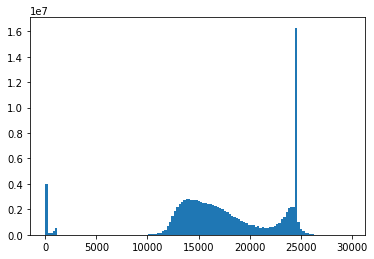

In [267]:
plt.hist(X_train.to_numpy().ravel(), 128);
# notice the cappings around 0 and 25000 we need to scale to make sure we have similiar pixel measurments in our data

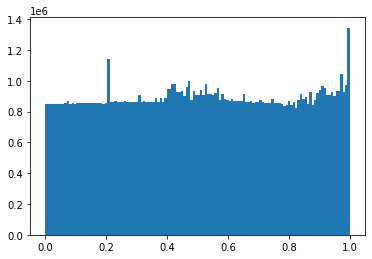

In [27]:
# equalized train dataset
plt.hist(equalized_train.to_numpy().ravel(), 128);


### Display Example Images

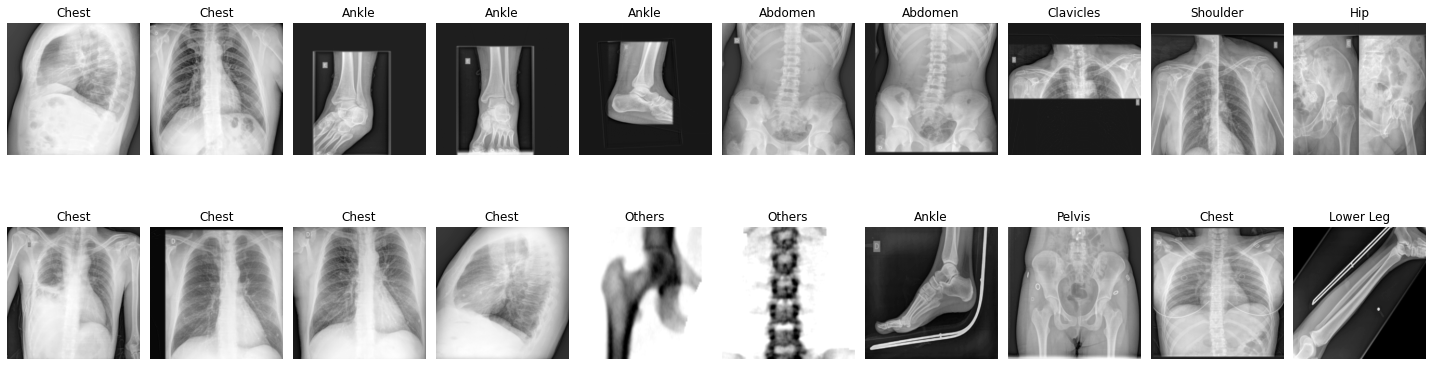

In [204]:
plt.figure(figsize=(20,20))
show_images(train_files, 20, class_names = train_data['Label'])
# without exposure equalizing

## Looking at Images with Exposure Transformation

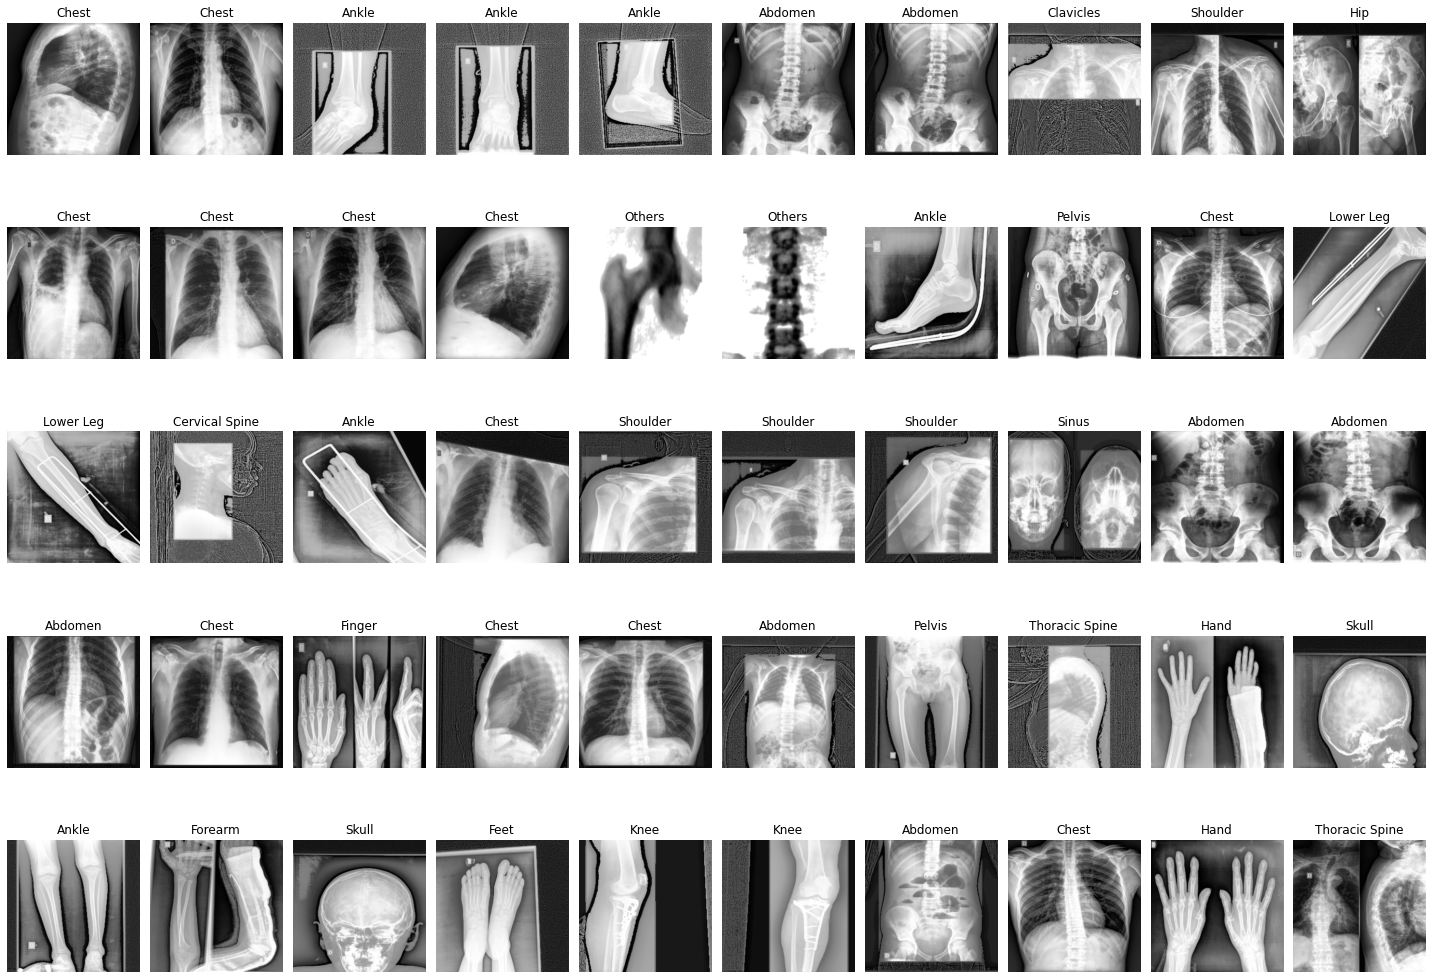

In [270]:
plt.figure(figsize=(20,20))
show_images(train_files, 50, class_names = train_data['Label'], exp_equal=True)

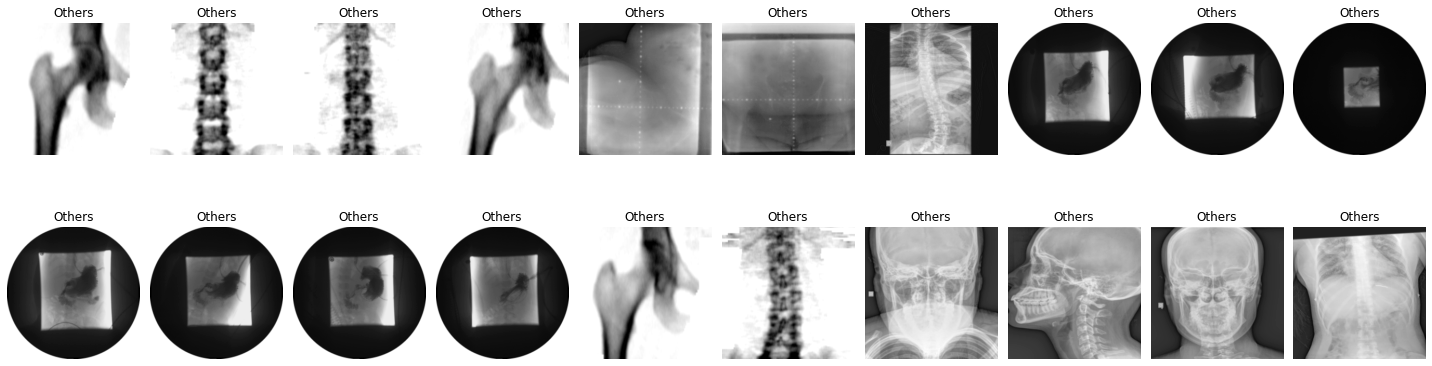

In [394]:
# look at some of the samples that are classified as 'Others'
others_files = [file for index, file in enumerate(train_files) if index in others_indices]

plt.figure(figsize=(20,20))
show_images(others_files, class_names=train_data['Label'],others =True,)

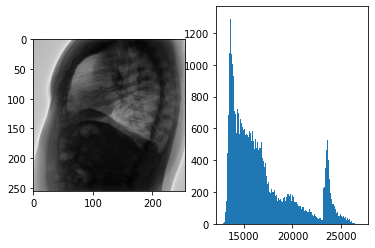

In [260]:
# Show an image with its histogram
im = pydicom.dcmread(train_files[0]).pixel_array
plt.subplot(1,2,1)
plt.imshow(im, cmap = "gray")
plt.subplot(1,2,2)
plt.hist(im.ravel(), 256);

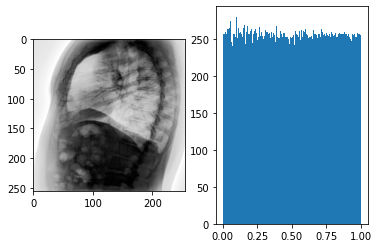

In [377]:
# Show an image with its histogram and exposure equalized
im_eq = exp.equalize_hist(im)
plt.subplot(1,2,1)
plt.imshow(im_eq, cmap='gray')
plt.subplot(1,2,2)
plt.hist(im_eq.ravel(), 256);


In [47]:
train_data.corr()

# Prepare the Data

### Transformations which could be useful:
- Using SIFT - adds new features to dataset based on important features in an image [SIFT](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_sift.html)
- Looking for pixel rows which are usually black which could lead to using dimensionality reduction, we can dispose of mostly black regions
- Scale data
- Find instances that arent DICOM files
- Exposure equalizing histograms - ```exp.equalize_hist```
- Cropping and resizing particular instances which look different from the usual xray - probably has to be done manually
- Blurring the image
- Inverting images with alot of white around the edges 

In [385]:
X_train.shape

(1738, 65536)

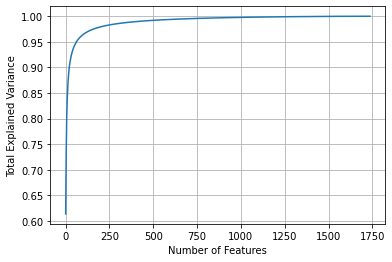

In [384]:
pca = PCA()  # PCA that keeps the same number of features as the original
pca.fit(X_train, y_train)

plt.figure()
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel("Number of Features")
plt.ylabel("Total Explained Variance")
plt.grid()

In [386]:
def plot_xrays(xrays):
    """Displays xray data"""
    plt.figure()
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(xrays[i].reshape(256, 256), cmap='gray')
        plt.axis('off')
    plt.tight_layout()

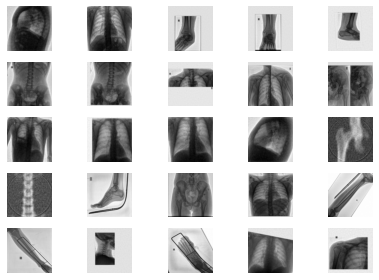

In [392]:
pca = PCA(n_components = .999)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)
plot_xrays(X_recovered)


In [393]:
X_reduced.shape

(1738, 1250)

In [6]:
class EqualizeImageHistogramTransformer():
    """
    Custom Transformer used for preprocessing images
    """
    def __init__(self):
        super().__init__()
        

    def fit(self, X, y=None, **kwargs):
        return self

    def transform(self, X):
        # three things need to happen here
        # each row needs to be read as an image
        # we need to apply the exposure- equalize-hist function to each row
        # we need to reload the data as X

        X = X.apply(exp.equalize_hist, axis=1,raw = True, result_type = "expand")

        return X

In [7]:
# preprocessor for preparing the data
preprocessor = Pipeline([
    ('exp-equal-hist', EqualizeImageHistogramTransformer()),
    ('scaling', MinMaxScaler()),
    ('blurring', FunctionTransformer(filters.gaussian)),
    ('pca', PCA(n_components=.999))
    # look at cropping and resizing with jeff functions
])
transformed_data = preprocessor.fit_transform(X_train)


# Short-List Promising Models
- We are doing multioutput classification so all of our Classifiers will be wrapped in the MultiOutputClassifier

In [8]:
def show_predictions_for_clf(train, preds, num_samples =10):
   """
   Displays images and there predicted label for xrays 
   train is the data the classifier was trained on
   preds are the predicted labels from the classifier
   """
   for i, pred in enumerate(preds[:num_samples]):
        plt.subplot(10, 10, i+1)
        lbl =classes_to_body_parts[np.argmax(pred)]
        plt.title(lbl)
        plt.imshow(X_train.iloc[i].to_numpy().reshape(256, 256), cmap='gray')
        plt.axis('off')
   plt.tight_layout()

## KNeighbors Classifier
- Notes: 
    - Base model achieved 59% cross val accuracy w/o any hyper param tuning or preprocessing steps
    - 64% f1_score


In [9]:
knn = MultiOutputClassifier(KNeighborsClassifier()).fit(X_train, y_train)
knn_scores = cross_val_score(knn, X_train, y_train, cv=3, scoring="accuracy", n_jobs =-1, verbose=3)
y_preds = cross_val_predict(knn, X_train, y_train, cv =3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ................................ score: (test=0.616) total time= 1.9min
[CV] END ................................ score: (test=0.607) total time= 1.9min
[CV] END ................................ score: (test=0.568) total time= 1.9min


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.0min finished


In [10]:
knn_scores.mean()

0.5971084382214941

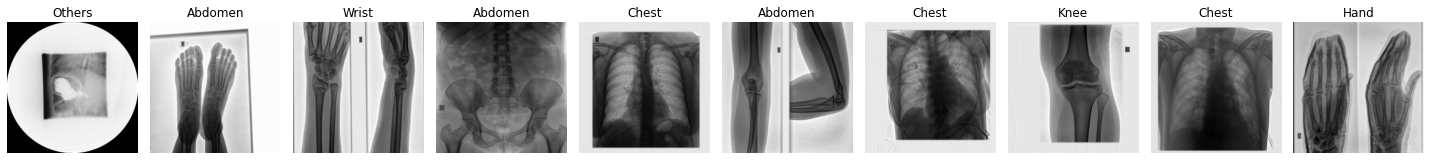

In [239]:
plt.figure(figsize=(20,20))
show_predictions_for_clf(X_train, y_preds)

In [11]:
f1_score(y_train, y_preds, average ="weighted")

NameError: name 'f1_score' is not defined

## Random Forest Classifier
Notes: Base Model 

In [135]:
rf = MultiOutputClassifier(RandomForestClassifier()).fit(X_train, y_train)
rf_scores = cross_val_score(rf, X_train, y_train, cv=3, scoring="accuracy", n_jobs =-1, verbose=3)
y_preds = cross_val_predict(rf, X_train, y_train, cv =3, verbose =2)

In [ ]:
rf_scores.mean()

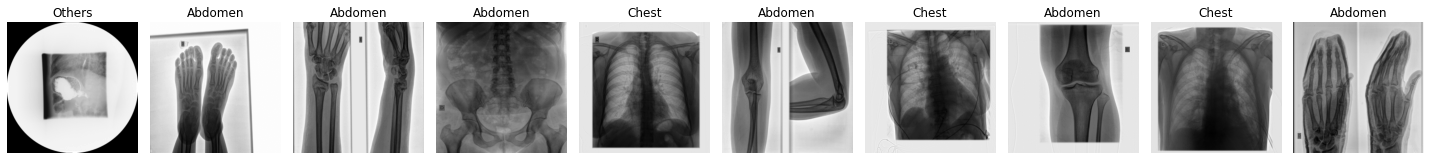

In [136]:
plt.figure(figsize=(20,20))
show_predictions_for_clf(X_train, y_preds)

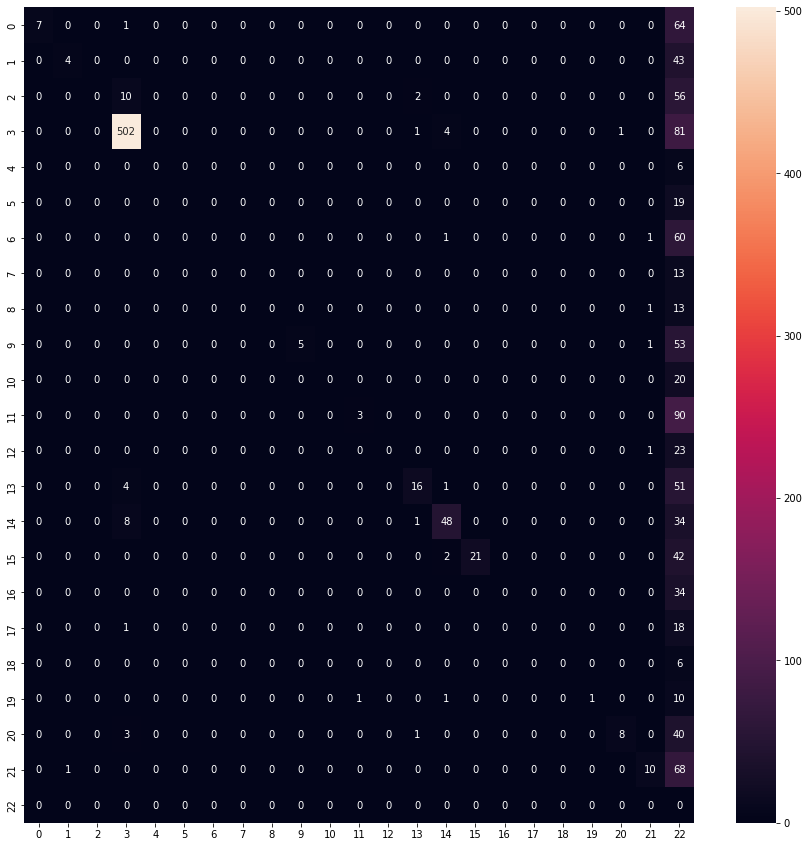

In [183]:
plt.figure(figsize=(15, 15))
from mlcm import mlcm
conf_mat,normal_conf_mat = mlcm.cm(y_train,y_preds, print_note = False)
sns.heatmap(conf_mat, annot = True, fmt = "1");

## ExtraTreeClassifier
- Extra Trees wasn't too bad achieving an accuracy score of about 50% for the cross validation
- We are going to proceed with KNN for our sklearn model since it achieved the highest accuracy

In [18]:
extra_trees = MultiOutputClassifier(ExtraTreesClassifier()).fit(X_train, y_train)
extra_trees_scores = cross_val_score(extra_trees, X_train, y_train, cv=3, scoring="accuracy", n_jobs =-1, verbose=3)
y_preds = cross_val_predict(extra_trees, X_train, y_train, cv =3, verbose =2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ................................ score: (test=0.464) total time= 1.8min
[CV] END ................................ score: (test=0.517) total time= 1.9min
[CV] END ................................ score: (test=0.499) total time= 1.9min


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.7min finished


In [20]:
extra_trees_scores.mean()

0.49350810555845187

# Tensor Flow Neural Net

In [232]:
## ZACH TODO
model = keras.models.Sequential()
model.add(keras.layers.Dense(200, input_dim=X_train.shape[1], activation='relu'))
for i in range(20):
    model.add(keras.layers.Dense(100-i*5, kernel_initializer='he_uniform', activation='relu'))
model.add(keras.layers.Dense(22, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])



# model.add(keras.layers.Conv2D(16,(3,3),  activation = "relu"))
# model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
# # output layer 
# model.add(keras.layers.Dense(22, activation = "softmax"))

In [229]:
model.compile(optimizer = "sgd", loss = "sparse_categorical_crossentropy", metrics = ["accuracy", "f1_score"])

In [233]:
model.fit(X_train, y_train, epochs = 20, validation_data = (X_valid, y_valid))

Epoch 1/20
44/44 [==============================] - 4s 53ms/step - loss: 12862.4717 - accuracy: 0.1353 - val_loss: 0.6848 - val_accuracy: 0.0172
Epoch 2/20
44/44 [==============================] - 2s 44ms/step - loss: 0.6767 - accuracy: 0.0065 - val_loss: 0.6677 - val_accuracy: 0.0172
Epoch 3/20
44/44 [==============================] - 2s 44ms/step - loss: 0.6595 - accuracy: 0.2101 - val_loss: 0.6507 - val_accuracy: 0.4224
Epoch 4/20
44/44 [==============================] - 2s 42ms/step - loss: 0.6428 - accuracy: 0.4173 - val_loss: 0.6341 - val_accuracy: 0.4224
Epoch 5/20
44/44 [==============================] - 2s 44ms/step - loss: 0.6265 - accuracy: 0.4173 - val_loss: 0.6179 - val_accuracy: 0.4224
Epoch 6/20
44/44 [==============================] - 2s 46ms/step - loss: 0.6105 - accuracy: 0.4173 - val_loss: 0.6021 - val_accuracy: 0.4224
Epoch 7/20
44/44 [==============================] - 2s 44ms/step - loss: 0.5950 - accuracy: 0.4173 - val_loss: 0.5867 - val_accuracy: 0.4224
Epoch 8/2

In [65]:
y_train.shape, MultiLabelBinarizer().fit_transform(y_train).shape

((1738,), (1738, 22))

# Fine Tune The Model

- Decided to use KNeighbors Classifier due to the accuracy we were getting for the base model
- Hopefully we can optimize our model to achieve even better results
- Factoring in our preprocessing steps may also help the models performance

In [23]:
# TODO Figure out best model - ensemble?, CNN?, 

model = Pipeline([
    ('preprocessor', preprocessor),
    ('MOC-KNN', MultiOutputClassifier(KNeighborsClassifier()))
])

In [24]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('exp-equal-hist',
                                  <__main__.EqualizeImageHistogramTransformer object at 0x7fcf911a2df0>),
                                 ('scaling', MinMaxScaler()),
                                 ('blurring',
                                  FunctionTransformer(func=<function gaussian at 0x7fcf90a46af0>)),
                                 ('pca', PCA(n_components=0.999))])),
                ('MOC-KNN',
                 MultiOutputClassifier(estimator=KNeighborsClassifier()))])

In [25]:
model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'MOC-KNN', 'preprocessor__memory', 'preprocessor__steps', 'preprocessor__verbose', 'preprocessor__exp-equal-hist', 'preprocessor__scaling', 'preprocessor__blurring', 'preprocessor__pca', 'preprocessor__scaling__clip', 'preprocessor__scaling__copy', 'preprocessor__scaling__feature_range', 'preprocessor__blurring__accept_sparse', 'preprocessor__blurring__check_inverse', 'preprocessor__blurring__func', 'preprocessor__blurring__inv_kw_args', 'preprocessor__blurring__inverse_func', 'preprocessor__blurring__kw_args', 'preprocessor__blurring__validate', 'preprocessor__pca__copy', 'preprocessor__pca__iterated_power', 'preprocessor__pca__n_components', 'preprocessor__pca__random_state', 'preprocessor__pca__svd_solver', 'preprocessor__pca__tol', 'preprocessor__pca__whiten', 'MOC-KNN__estimator__algorithm', 'MOC-KNN__estimator__leaf_size', 'MOC-KNN__estimator__metric', 'MOC-KNN__estimator__metric_params', 'MOC-KNN__estimator__n_jobs', 'MOC-

In [29]:
param_grid = [
    # No preprocessing
    {'preprocessor':[None], 'MOC-KNN__estimator__leaf_size': [10, 20, 50]},
    # Taking out the exposure hist equalization
    {'preprocessor__exp-equal-hist':[None], 'MOC-KNN__estimator__leaf_size': [10, 20, 50]},
    {'preprocessor__blurring':[None], 'MOC-KNN__estimator__leaf_size': [10, 20, 50]},
    {'preprocessor__pca__n_components':[.97, .99, .999], 'MOC-KNN__estimator__leaf_size': [10, 20, 50]},


]

search = GridSearchCV(model, param_grid=param_grid, scoring="accuracy", verbose =2, cv=3,  error_score='raise')

In [30]:
search.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END MOC-KNN__estimator__leaf_size=10, preprocessor=None; total time=  41.8s
[CV] END MOC-KNN__estimator__leaf_size=10, preprocessor=None; total time=  48.0s
[CV] END MOC-KNN__estimator__leaf_size=10, preprocessor=None; total time=  42.8s
[CV] END MOC-KNN__estimator__leaf_size=20, preprocessor=None; total time=  40.6s
[CV] END MOC-KNN__estimator__leaf_size=20, preprocessor=None; total time=  39.3s
[CV] END MOC-KNN__estimator__leaf_size=20, preprocessor=None; total time=  39.5s
[CV] END MOC-KNN__estimator__leaf_size=50, preprocessor=None; total time=  39.5s
[CV] END MOC-KNN__estimator__leaf_size=50, preprocessor=None; total time=  41.5s
[CV] END MOC-KNN__estimator__leaf_size=50, preprocessor=None; total time=  39.1s
[CV] END MOC-KNN__estimator__leaf_size=10, preprocessor__exp-equal-hist=None; total time=  23.4s
[CV] END MOC-KNN__estimator__leaf_size=10, preprocessor__exp-equal-hist=None; total time=  22.9s
[CV] END MOC-KNN

In [51]:
search.best_params_, search.best_score_

({'preprocessor': None}, 0.422286561902634)

In [58]:
search.cv_results_['mean_test_score']

array([0.42228656, 0.18920055,        nan,        nan,        nan,
              nan,        nan,        nan,        nan])

In [ ]:
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(search, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# output test results to csv in format [Sample, Predicted]